QA of MWS mock

# Setup

In [1]:
sys_path_hack_in = [
    '/gpfs/data/dph3apc/desi/modules/desitarget/gaiaselect/lib/python3.5/site-packages/desitarget-0.9.0-py3.5.egg',
    '/gpfs/data/dph3apc/desi/modules/bright_analysis/dev/lib/python3.5/site-packages/bright_analysis-c2a60b4.dev9-py3.5.egg',
    '/gpfs/data/dph3apc/desi/galaxia/runs/allsky20nowarp_subjobs/',
]

sys_path_hack_out = [
    '/cosma/home/dph3apc/modules/desi_stack/python3/bright_analysis/dev/lib/python3.5/site-packages',
    '/gpfs/data/DESI/software/modules/desitarget/0.9.0/lib/python3.5/site-packages/desitarget-0.9.0-py3.5.egg',   
    '/gpfs/data/DESI/software/modules/desitarget/0.9.0/lib/python3.5/site-packages',
]

import sys
for t in sys_path_hack_out:
    if t in sys.path: 
        print('Removing path:',t)
        sys.path.remove(t)
        
for t in sys_path_hack_in:
    if not t in sys.path: 
        print('Adding path:',t)
        sys.path.append(t)

Removing path: /cosma/home/dph3apc/modules/desi_stack/python3/bright_analysis/dev/lib/python3.5/site-packages
Removing path: /gpfs/data/DESI/software/modules/desitarget/0.9.0/lib/python3.5/site-packages/desitarget-0.9.0-py3.5.egg
Removing path: /gpfs/data/DESI/software/modules/desitarget/0.9.0/lib/python3.5/site-packages
Adding path: /gpfs/data/dph3apc/desi/modules/desitarget/gaiaselect/lib/python3.5/site-packages/desitarget-0.9.0-py3.5.egg
Adding path: /gpfs/data/dph3apc/desi/modules/bright_analysis/dev/lib/python3.5/site-packages/bright_analysis-c2a60b4.dev9-py3.5.egg
Adding path: /gpfs/data/dph3apc/desi/galaxia/runs/allsky20nowarp_subjobs/


In [2]:
import desitarget
desitarget.__path__

# Python imports
from importlib import reload
import os
import numpy as np
import astropy.io.fits as fits
import astropy.coordinates as c
from astropy.table import Table
import astropy.units as u
import mpl_toolkits.basemap
import matplotlib.pyplot as pl
import astropy.table as apy_table

# Desi-specific imports
import desitarget
reload(desitarget)
import desitarget.io
import desitarget.mock.io as mock_io
from desitarget import mws_mask, bgs_mask, desi_mask
reload(mock_io)
import desiutil.plots as desiplots
import bright_analysis
import bright_analysis.sweeps.io as sweeps
reload(sweeps);

import numpy.ma as ma

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
mockdir = '/gpfs/data/dph3apc/desi/galaxia/runs/allsky_20_nowarp_subjobs_2.0/healpix/'

In [5]:
ls /gpfs/data/dph3apc/desi/galaxia/runs/allsky_20_nowarp_subjobs_2.0/healpix/0/8-0/mock_allsky_galaxia_desi-8-0.fits

/gpfs/data/dph3apc/desi/galaxia/runs/allsky_20_nowarp_subjobs_2.0/healpix/0/8-0/mock_allsky_galaxia_desi-8-0.fits


# Read data

In [6]:
mockfiles = desitarget.io.iter_files(mockdir,'mock_allsky_galaxia_desi','fits')

In [7]:
%time t = apy_table.vstack([Table.read(_) for _ in mockfiles],metadata_conflicts='silent')

CPU times: user 9min 10s, sys: 2min 46s, total: 11min 57s
Wall time: 13min 27s


In [8]:
len(t)

53880068

In [9]:
t[0:2]

X,Y,Z,l,b,RA,DEC,pm_l,pm_b,pm_RA,pm_DEC,pm_l_kms,pm_b_kms,pm_RA_kms,pm_DEC_kms,v_helio,d_helio,DM,ABV,SDSSu_true_nodust,SDSSu_true,SDSSu_obs,SDSSg_true_nodust,SDSSg_true,SDSSg_obs,SDSSr_true_nodust,SDSSr_true,SDSSr_obs,SDSSi_true_nodust,SDSSi_true,SDSSi_obs,SDSSz_true_nodust,SDSSz_true,SDSSz_obs,FeH,age,teff,logg,mtip,mact,smass,popid,brickname,brickid,ipix8,vU,vV,vW,vRcyl,vPHIcyl,vZcyl,vX,vY,vZ,objid
kpc,kpc,kpc,deg,deg,deg,deg,,,,,km / s,km / s,km / s,km / s,km / s,kpc,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,,,,,,,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,
float32,float32,float32,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,str8,int64,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64
8.05609,-0.0031872,-0.0544833,176.748,-44.123,48.3400350865,3.42405599749,0.478119,0.495626,0.59497961359,0.0971678122878,0.177355,0.183849,0.220703688252,0.0360437468133,29.6793,0.0782581,4.46765,0.0544807,19.7357,20.0165,20.0165,16.8983,17.105,17.105,15.4976,15.6475,15.6475,14.5629,14.6766,14.6766,14.0166,14.0972,14.0972,0.0448923,9.33165,3.54786,5.03874,1.61248,0.23921,0.23921,3,0450p000,215,0,-35.0588,-11.0304,-7.18502,24.049,-228.04,0.0649819,23.9588,-228.05,0.0649819,0
8.03681,-0.00852647,-0.0393537,166.959,-46.1635,41.8414490354,6.56283663899,1.24352,-0.687634,0.245824502997,-1.0743316412,0.32158,-0.177825,0.0635713511828,-0.27782712145,25.5048,0.0545579,3.68429,0.0463266,19.3136,19.5524,19.5524,16.4399,16.6156,16.6156,15.0239,15.1513,15.1513,14.0466,14.1432,14.1432,13.4761,13.5446,13.5446,0.0525269,9.4766,3.54207,5.06173,1.46374,0.213253,0.213253,3,0450p100,251,0,-6.26606,-32.0387,-36.4386,-4.61428,-207.046,-29.1886,-4.83394,-207.041,-29.1886,1


### Randomly downsample

In [15]:
rsample = np.random.choice(np.arange(0,len(t)),1000000,replace=False)

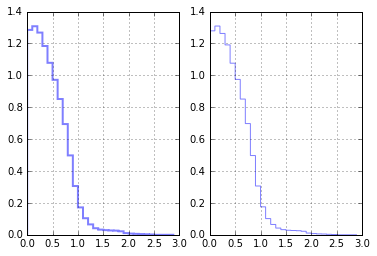

In [16]:
_f = figure()
ax = _f.add_subplot(121)
hist(np.log10(np.abs(t['d_helio'])),bins=np.arange(0,3,0.1),alpha=0.5,histtype='step',ls='solid',lw=2,normed=True);
grid();
ax = _f.add_subplot(122)
hist(ma.log10(np.abs(t['d_helio'][rsample])),bins=np.arange(0,3,0.1),alpha=0.5,histtype='step',normed=True);
grid();

# Positions

In [10]:
gc_gal = c.SkyCoord(0*u.deg,0*u.deg,frame='galactic')
gc_equ = gc_gal.transform_to('icrs')

Equatorial

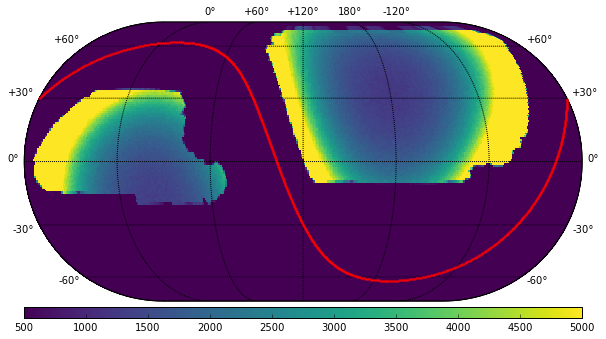

In [11]:
f = figure(figsize=(10,10))
my_basemap = desiplots.init_sky(projection='eck4', galactic_plane_color='r',
                                ra_labels=np.arange(-90, 90, 30), 
                                dec_labels=np.arange(0, 360, 60), 
                                ax=None)
ax = desiplots.plot_sky_binned(t['RA'],t['DEC'],max_bin_area=1.0,clip_lo=100*5,clip_hi=1000*5,basemap=my_basemap);
grid()

Galactic

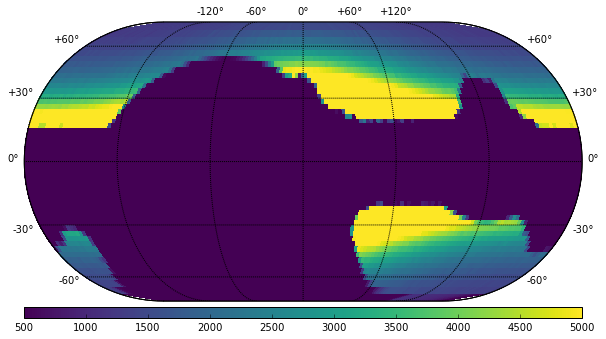

In [12]:
f = figure(figsize=(10,10))
my_basemap = desiplots.init_sky(projection='eck4', ra_center=0, galactic_plane_color='None',
                                ra_labels=np.arange(-90, 90, 30), 
                                dec_labels=np.arange(0, 360, 60), 
                                ax=None)
desiplots.plot_sky_binned(t['l'],t['b'],max_bin_area=5.0,clip_lo=100*5,clip_hi=1000*5,basemap=my_basemap);
grid()

Galactocentric cartesian coordinates

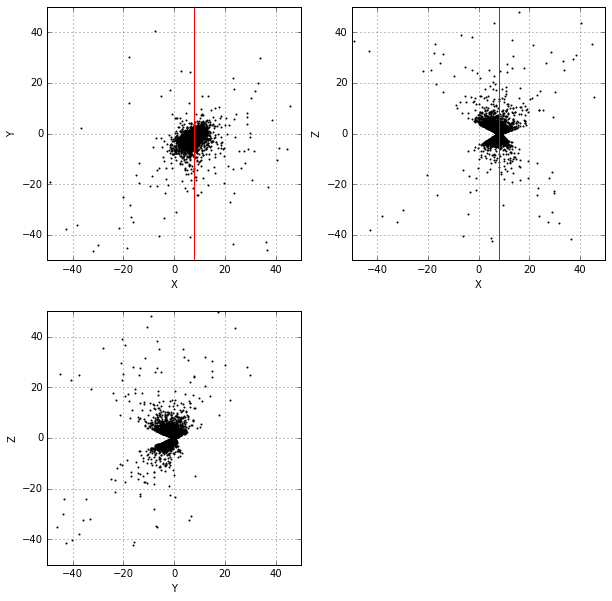

In [17]:
_f = figure(figsize=(10,10))
ax = _f.add_subplot(221)
scatter(t['X'][rsample[::100]],t['Y'][rsample[::100]],s=1,c='k',alpha=1);
xlim(-50,50)
xlabel('X')
ylim(-50,50)
ylabel('Y')
axvline(8,c='r')
grid()
ax = _f.add_subplot(222)
scatter(t['X'][rsample[::100]],t['Z'][rsample[::100]],s=1,c='k',alpha=1);
xlim(-50,50)
xlabel('X')
ylim(-50,50)
ylabel('Z')
axvline(8,c='r')
grid()
ax = _f.add_subplot(223)
scatter(t['Y'][rsample[::100]],t['Z'][rsample[::100]],s=1,c='k',alpha=1);
xlim(-50,50)
xlabel('Y')
ylim(-50,50)
ylabel('Z')
grid()

# Kinematics

### PM in Galactic latitude,  equatorial coordinates, 

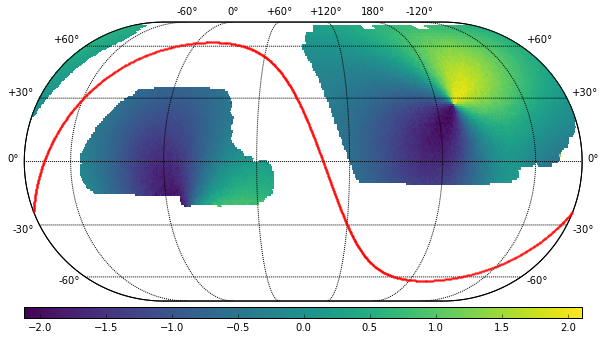

In [18]:
f = figure(figsize=(10,10))
my_basemap_radec = desiplots.init_sky(projection='eck4', ra_center=90, galactic_plane_color='r',ra_labels=np.arange(-90, 90, 30), 
                                dec_labels=np.arange(0, 360, 60), ax=None)
desiplots.plot_sky_binned(t['RA'],t['DEC'],data=t['pm_b'],clip_lo=-10,clip_hi=10,max_bin_area=1.0,basemap=my_basemap_radec);
grid()

### PM in Galactic longitude, equatorial coordinates 

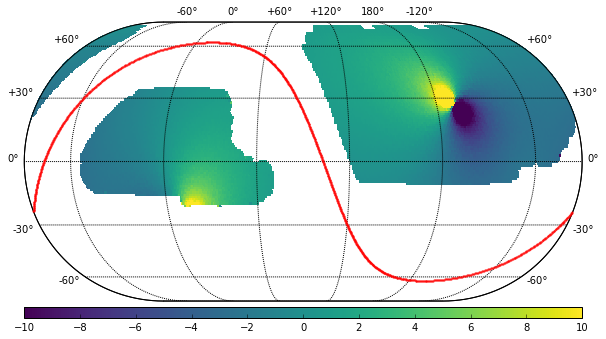

In [19]:
f = figure(figsize=(10,10))
my_basemap_radec = desiplots.init_sky(projection='eck4', ra_center=90, galactic_plane_color='r',ra_labels=np.arange(-90, 90, 30), 
                                dec_labels=np.arange(0, 360, 60), ax=None)
desiplots.plot_sky_binned(t['RA'],t['DEC'],data=t['pm_l'],clip_lo=-10,clip_hi=10,max_bin_area=1.0,basemap=my_basemap_radec);
grid()

### Magnitude of PM, equatorial coordintes

In [20]:
pmtot    = np.sqrt(t['pm_RA']**2+t['pm_DEC']**2)

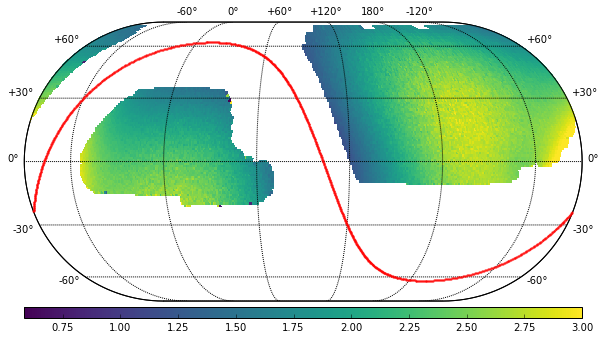

In [21]:
f = figure(figsize=(10,10))
my_basemap_radec = desiplots.init_sky(projection='eck4', ra_center=90, galactic_plane_color='r',ra_labels=np.arange(-90, 90, 30), 
                                dec_labels=np.arange(0, 360, 60), ax=None)
desiplots.plot_sky_binned(t['RA'],t['DEC'],data=pmtot,max_bin_area=1.0,clip_lo=0,clip_hi=3,
        basemap=my_basemap_radec);
grid()

### Magnitude of PM, Galactic coordinates

In [22]:
pmtot_lb = np.sqrt(t['pm_l']**2+t['pm_b']**2)

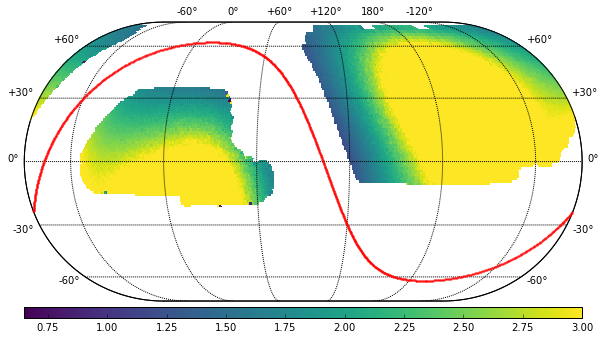

In [23]:
f = figure(figsize=(10,10))
my_basemap_radec = desiplots.init_sky(projection='eck4', ra_center=90, galactic_plane_color='r',ra_labels=np.arange(-90, 90, 30), 
                                dec_labels=np.arange(0, 360, 60), ax=None)
desiplots.plot_sky_binned(t['RA'],t['DEC'],data=pmtot_lb,max_bin_area=1.0,clip_lo=0,clip_hi=3,
        basemap=my_basemap_radec);
grid()

These aren't consistent? My GAL->EQU conversion was taken from Galfast; this disagrees with Pygaia and Astropy's GAL->ICRS. 

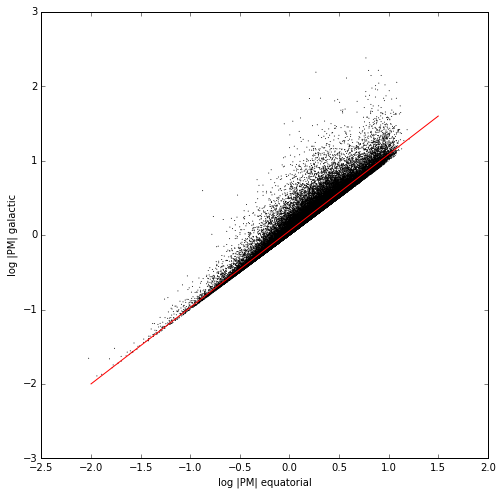

In [24]:
_f = figure(figsize=(8,8))
scatter(np.log10(pmtot[::1000]),np.log10(pmtot_lb[::1000]),s=1,edgecolor='None',c='k');
plot([-2,1.5],[-2,1.6],c='r')
xlabel('log |PM| equatorial')
ylabel('log |PM| galactic');

### PM in Galactic latitude, Galactic coordinates

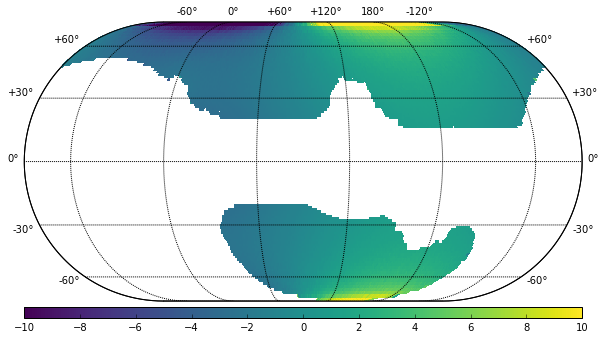

In [25]:
f = figure(figsize=(10,10))
my_basemap = desiplots.init_sky(projection='eck4', ra_center=90, 
                                galactic_plane_color='None',ra_labels=np.arange(-90, 90, 30), 
                                dec_labels=np.arange(0, 360, 60), ax=None)
desiplots.plot_sky_binned(t['l'],t['b'],data=t['pm_l'],max_bin_area=1.0,clip_lo=-10,clip_hi=10,basemap=my_basemap);
grid()

### Velocity in Galactic latitude, Galactic coordinates

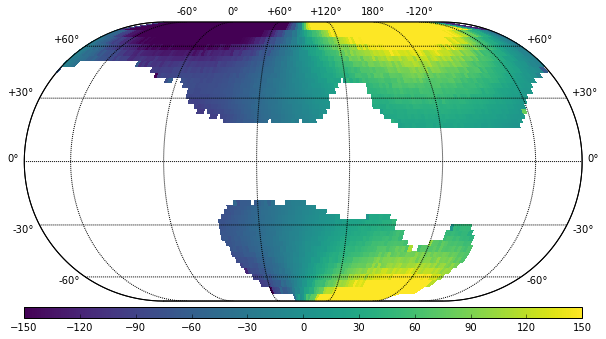

In [26]:
f = figure(figsize=(10,10))
my_basemap = desiplots.init_sky(projection='eck4', ra_center=90, galactic_plane_color='None',ra_labels=np.arange(-90, 90, 30), 
                                dec_labels=np.arange(0, 360, 60), ax=None)
desiplots.plot_sky_binned(t['l'],t['b'],data=t['pm_l_kms'],max_bin_area=5.0,clip_lo=-150,clip_hi=150,basemap=my_basemap);
grid()

### Heliocentric RV, equatorial coordinates

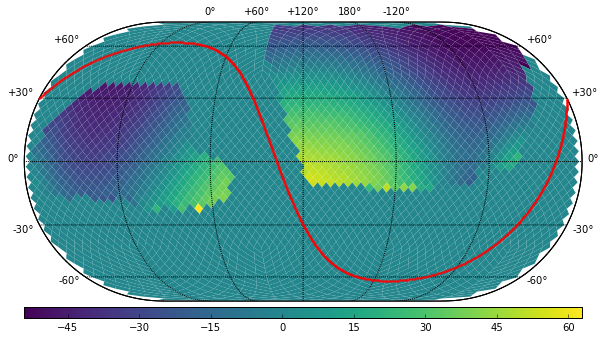

In [27]:
f = figure(figsize=(10,10))
desiplots.plot_sky_binned(t['RA'],t['DEC'],data=t['v_helio'],
                          plot_type='healpix',
                          max_bin_area=30.0,clip_lo=-500,clip_hi=500);
grid()

### Heliocentric RV, Galactic coordinates (scatterplot)

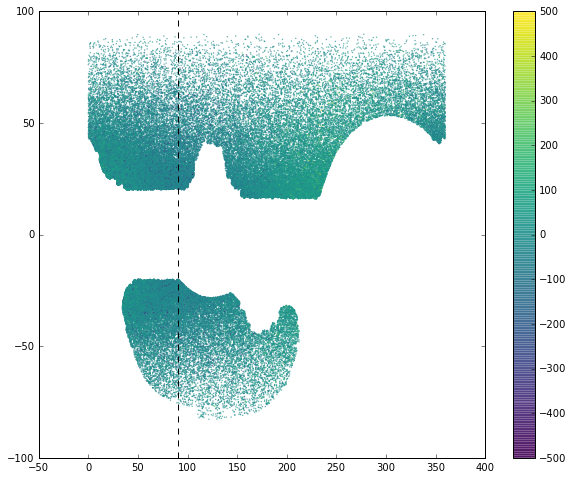

In [28]:
figure(figsize=(10,8))
vh_norm = Normalize(vmin=-500,vmax=500)
pl.scatter(t['l'][rsample[::10]],t['b'][rsample[::10]],s=2,edgecolor='None',
           alpha=0.7,
           c=t['v_helio'][rsample[::10]],norm=vh_norm,
           cmap='viridis');
colorbar();
axvline(90,c='k',ls='--');

### Heliocentric RV, Galactic coordinates (binned without projection)

In [29]:
import scipy.stats as sps
binsize = 5
lbins   = np.arange(0,360+binsize,binsize)
bbins   = np.arange(-90,90+binsize,binsize)
_h,_ex,_ey,_bn = sps.binned_statistic_2d(t['l'][rsample],t['b'][rsample],
                                         t['v_helio'][rsample],

                                         bins=(lbins,bbins),statistic='mean')

-125.064208031 103.953262329 -10.6144245236


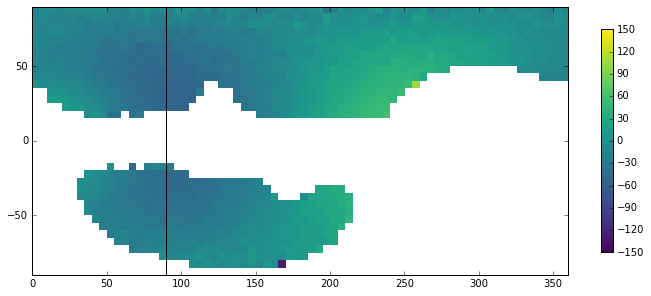

In [30]:
figure(figsize=(12,8))
_i = np.isfinite(_h)
print(_h[_i].min(),_h[_i].max(),np.median(_h[_i]))
imshow(_h.T,origin='lower',extent=(_ex[0],_ex[-1],_ey[0],_ey[-1]),interpolation='nearest',vmin=-150,vmax=150,
       cmap='viridis');
colorbar(shrink=0.5);
axvline(90,c='k');

### Equatorial PMs (histogram)

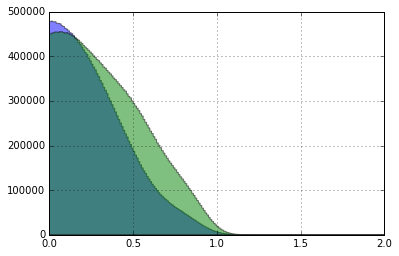

In [31]:
hist(ma.log10(np.abs(t['pm_RA'])),bins=np.arange(0,2.01,0.01),alpha=0.5,histtype='stepfilled');
hist(ma.log10(np.abs(t['pm_DEC'])),bins=np.arange(0,2.01,0.01),alpha=0.5,histtype='stepfilled');
grid();

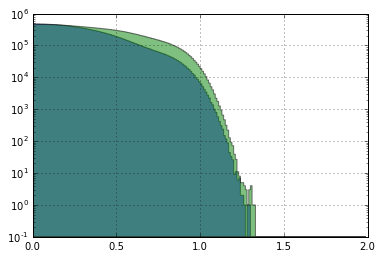

In [32]:
hist(np.log10(ma.abs(t['pm_RA'])),bins=np.arange(0,2,0.01),alpha=0.5,histtype='stepfilled',log=True);
hist(ma.log10(ma.abs(t['pm_DEC'])),bins=np.arange(0,2,0.01),alpha=0.5,histtype='stepfilled',log=True);
grid();

### Galactic PMs (histogram)

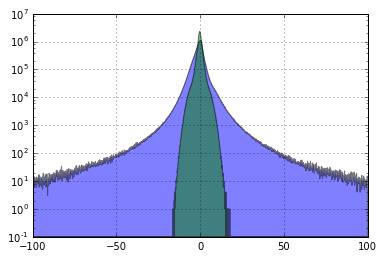

In [33]:
hist(t['pm_l'],bins=np.arange(-100,100,0.1),alpha=0.5,histtype='stepfilled',log=True);
hist(t['pm_b'],bins=np.arange(-100,100,0.1),alpha=0.5,histtype='stepfilled',log=True);
grid();

Zoom around zero PM

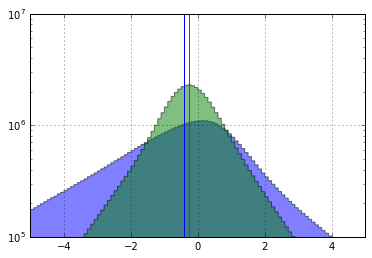

In [34]:
hist(t['pm_l'],bins=np.arange(-100,100,0.1),alpha=0.5,histtype='stepfilled',log=True);
hist(t['pm_b'],bins=np.arange(-100,100,0.1),alpha=0.5,histtype='stepfilled',log=True);

xlim(-5,5)
ylim(10**5,10**7)
pl.axvline(np.median(t['pm_l']),c='b')
pl.axvline(np.median(t['pm_b']),c='g')
grid();

Absolute value

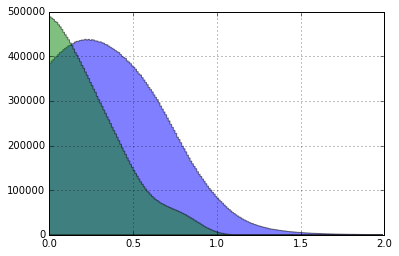

In [35]:
hist(np.log10(np.abs(t['pm_l'])),bins=np.arange(0,2,0.01),alpha=0.5,histtype='stepfilled');
hist(ma.log10(np.abs(t['pm_b'])),bins=np.arange(0,2,0.01),alpha=0.5,histtype='stepfilled');
grid();

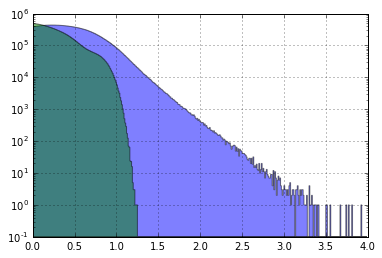

In [36]:
hist(np.log10(np.abs(t['pm_l'])),bins=np.arange(0,4,0.01),alpha=0.5,histtype='stepfilled',log=True);
hist(ma.log10(np.abs(t['pm_b'])),bins=np.arange(0,4,0.01),alpha=0.5,histtype='stepfilled',log=True);
grid();

Same thing in km/s.

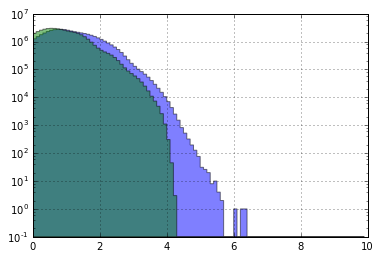

In [37]:
hist(ma.log10(np.abs(t['pm_l_kms'])),bins=np.arange(0,10,0.1),alpha=0.5,histtype='stepfilled',log=True);
hist(ma.log10(np.abs(t['pm_b_kms'])),bins=np.arange(0,10,0.1),alpha=0.5,histtype='stepfilled',log=True);
grid()

### Radial velocity (histograms)

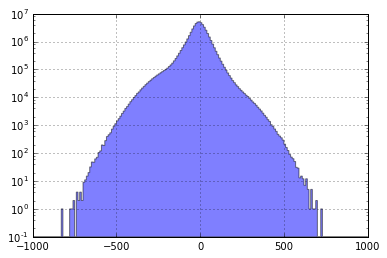

In [38]:
hist(t['v_helio'],bins=np.arange(-1000,1010,10.0),alpha=0.5,histtype='stepfilled',log='True');
grid();

### Tangential velocity (histograms)

Some crazy-high values here, thanks to the tails of `pm_l`.

2.35994e+06


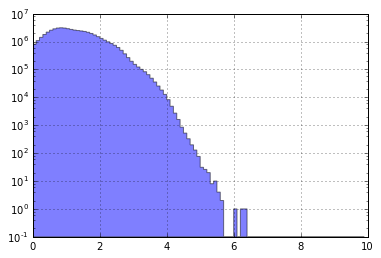

In [39]:
vtan = np.sqrt(t['pm_l_kms']**2 + t['pm_b_kms']**2)
print(vtan.max())
hist(ma.log10(vtan),bins=np.arange(0,10,0.1),alpha=0.5,histtype='stepfilled',log=True);
grid()

# Distance vs PM

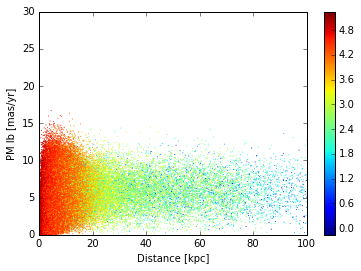

In [40]:
_s = scatter(t['d_helio'][rsample],pmtot[rsample],s=1,c=t['logg'][rsample],edgecolor='None')
colorbar(_s)
pl.xlabel('Distance [kpc]')
pl.ylabel('PM lb [mas/yr]')
pl.xlim(0,100)
pl.ylim(0,30);

(-50, 50)

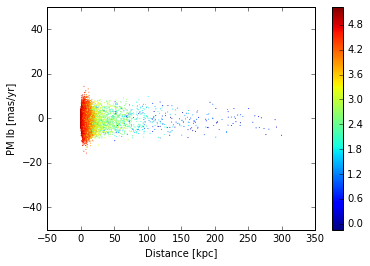

In [41]:
_s = scatter(t['d_helio'][rsample[::10]],t['pm_RA'][rsample[::10]],s=1,c=t['logg'][rsample[::10]],edgecolor='None')
colorbar(_s)
pl.xlabel('Distance [kpc]')
pl.ylabel('PM lb [mas/yr]')
ylim(-50,50)

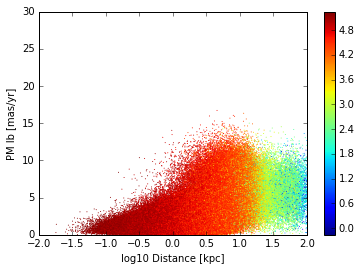

In [42]:
_s = scatter(np.log10(t['d_helio'][rsample]),pmtot[rsample],s=1,c=t['logg'][rsample],edgecolor='None')
colorbar(_s)
pl.xlabel('log10 Distance [kpc]')
pl.ylabel('PM lb [mas/yr]')
pl.xlim(-2,2)
pl.ylim(0,30);

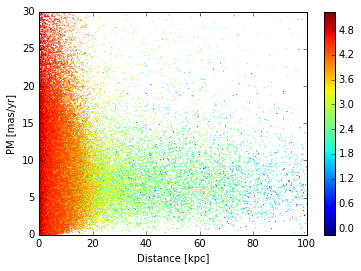

In [43]:
_s = scatter(t['d_helio'][rsample],pmtot_lb[rsample],c=t['logg'][rsample],s=1,edgecolor='None')
colorbar(_s)
pl.xlabel('Distance [kpc]')
pl.ylabel('PM [mas/yr]')
pl.xlim(0,100)
pl.ylim(0,30);

# Coordinates vs. PM

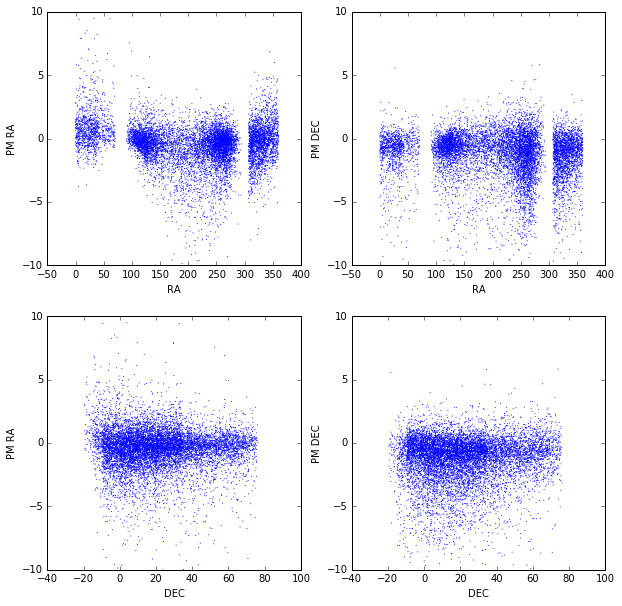

In [44]:
_f = figure(figsize=(10,10))

ax = _f.add_subplot(221)
pl.scatter(t['RA'][rsample[::100]],t['pm_RA'][rsample[::100]],s=1,edgecolor='None')
ylim(-10,10);
xlabel('RA')
ylabel('PM RA')
ax = _f.add_subplot(222)
pl.scatter(t['RA'][rsample[::100]],t['pm_DEC'][rsample[::100]],s=1,edgecolor='None')
ylim(-10,10);
xlabel('RA')
ylabel('PM DEC')
ax = _f.add_subplot(223)
pl.scatter(t['DEC'][rsample[::100]],t['pm_RA'][rsample[::100]],s=1,edgecolor='None')
ylim(-10,10);
xlabel('DEC')
ylabel('PM RA')
ax = _f.add_subplot(224)
pl.scatter(t['DEC'][rsample[::100]],t['pm_DEC'][rsample[::100]],s=1,edgecolor='None')
ylim(-10,10);
xlabel('DEC')
ylabel('PM DEC');

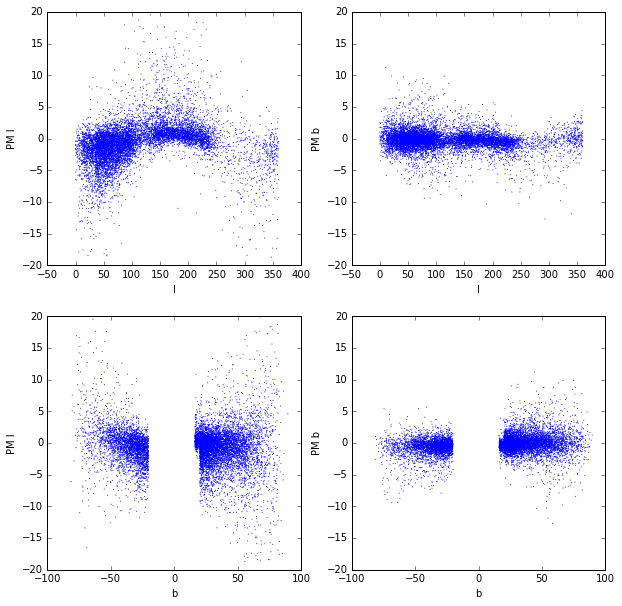

In [45]:
_f = figure(figsize=(10,10))

ax = _f.add_subplot(221)
pl.scatter(t['l'][rsample[::100]],t['pm_l'][rsample[::100]],s=1,edgecolor='None')
ylim(-20,20);
xlabel('l')
ylabel('PM l')
ax = _f.add_subplot(222)
pl.scatter(t['l'][rsample[::100]],t['pm_b'][rsample[::100]],s=1,edgecolor='None')
ylim(-20,20);
xlabel('l')
ylabel('PM b')
ax = _f.add_subplot(223)
pl.scatter(t['b'][rsample[::100]],t['pm_l'][rsample[::100]],s=1,edgecolor='None')
ylim(-20,20);
xlabel('b')
ylabel('PM l')
ax = _f.add_subplot(224)
pl.scatter(t['b'][rsample[::100]],t['pm_b'][rsample[::100]],s=1,edgecolor='None')
ylim(-20,20);
xlabel('b')
ylabel('PM b');

# Misc

In [46]:
all_gal = c.SkyCoord(t['l'],t['b'],frame='galactic')

In [ ]:
l90_gal = c.SkyCoord(90*u.deg,0*u.deg,frame='galactic')
l90_equ = l90_gal.transform_to('icrs')

l270_gal = c.SkyCoord(270*u.deg,0*u.deg,frame='galactic')
l270_equ = l270_gal.transform_to('icrs')

In [ ]:
# Select stars around l=90, b=0 (need quite a wide circle since the footprint doesn't get close to the plane)
nearl90 = all_gal.separation(l90_gal) < 60.0*u.deg

In [ ]:
# Select stars around l=270, b=0 (need quite a wide circle since the footprint doesn't get close to the plane)
nearl270 = all_gal.separation(l270_gal) < 60.0*u.deg

In [ ]:
wnearl90 = np.where(nearl90)[0]
wnearl90.shape

In [ ]:
wnearl270 = np.where(nearl270)[0]
wnearl270.shape

In [ ]:
f = figure(figsize=(10,10))
ax = pl.subplot(121)
my_basemap = desiplots.init_sky(projection='eck4', ra_center=0, galactic_plane_color='None',
                                ra_labels=np.arange(-90, 90, 30), 
                                dec_labels=np.arange(0, 360, 60), 
                                ax=ax)
desiplots.plot_sky_binned(t['l'][wnearl90],t['b'][wnearl90],max_bin_area=5.0,clip_lo=100*5,clip_hi=1000*5,basemap=my_basemap);
grid()
ax = pl.subplot(122)
my_basemap = desiplots.init_sky(projection='eck4', ra_center=0, galactic_plane_color='None',
                                ra_labels=np.arange(-90, 90, 30), 
                                dec_labels=np.arange(0, 360, 60), 
                                ax=ax)
desiplots.plot_sky_binned(t['l'][wnearl270],t['b'][wnearl270],max_bin_area=5.0,clip_lo=100*5,clip_hi=1000*5,basemap=my_basemap);
grid()

In [ ]:
pm_norm  = Normalize(-5,5)
vel_norm = Normalize(-100,100)

_f = figure(figsize=(12,6))
ax = _f.add_subplot(231)
scatter(t['X'][wnearl90[::1000]],t['Y'][wnearl90[::1000]],s=1,c='b',edgecolor='None',alpha=0.9)
scatter(t['X'][wnearl270[::1000]],t['Y'][wnearl270[::1000]],s=1,c='g',edgecolor='None',alpha=0.9)
pl.xlim(-50,50)
pl.ylim(-50,50)
ax = _f.add_subplot(232)
scatter(t['X'][wnearl90[::1000]],t['Y'][wnearl90[::1000]],s=1,c='b',edgecolor='None',alpha=0.9)
scatter(t['X'][wnearl270[::1000]],t['Y'][wnearl270[::1000]],s=1,c='g',edgecolor='None',alpha=0.9)
pl.xlim(0,16)
pl.ylim(-8,8)
ax = _f.add_subplot(233)
scatter(t['X'][wnearl90[::1000]],t['Y'][wnearl90[::1000]],s=1,c=t['pm_l'][wnearl90[::1000]],
        norm=pm_norm,
        edgecolor='None',alpha=0.9)
scatter(t['X'][wnearl270[::1000]],t['Y'][wnearl270[::1000]],s=1,c=t['pm_l'][wnearl270[::1000]],
        norm=pm_norm,
        edgecolor='None',alpha=0.9)
pl.xlim(0,16)
pl.ylim(-8,8)
colorbar();
ax = _f.add_subplot(234)
scatter(t['X'][wnearl90[::1000]],t['Y'][wnearl90[::1000]],s=1,c=t['vU'][wnearl90[::1000]],
        norm=vel_norm,
        edgecolor='None',alpha=0.9)
scatter(t['X'][wnearl270[::1000]],t['Y'][wnearl270[::1000]],s=3,c=t['vU'][wnearl270[::1000]],
        norm=vel_norm,
        edgecolor='None',alpha=0.9)
colorbar();
pl.xlim(0,16)
pl.ylim(-8,8)
ax = _f.add_subplot(235)
scatter(t['X'][wnearl90[::1000]],t['Y'][wnearl90[::1000]],s=1,c=t['vV'][wnearl90[::1000]],
        norm=vel_norm,
        edgecolor='None',alpha=0.9)
scatter(t['X'][wnearl270[::1000]],t['Y'][wnearl270[::1000]],s=3,c=t['vV'][wnearl270[::1000]],
        norm=vel_norm,
        edgecolor='None',alpha=0.9)
colorbar();
pl.xlim(0,16)
pl.ylim(-8,8)

In [ ]:
h90  = hist(t['v_helio'][wnearl90],bins=np.arange(-500,501,1),histtype='stepfilled',alpha=0.5,normed=True);
h270 = hist(t['v_helio'][wnearl270],bins=np.arange(-500,501,1),histtype='stepfilled',alpha=0.5,normed=True);
xlim(-50,50)
axvline(0,c='k')
axvline(np.median(t['v_helio'][wnearl90]), color='b',ls='--')
axvline(np.median(t['v_helio'][wnearl270]),color='g',ls='--')